# Milne

In [1]:
#All libraries necesary:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sin, cos
from copy import deepcopy
from mutils2 import *
import time
# import seaborn
from milne import *

----------------------------------------------------
Element = SI1
lambda0 = 10827.089
ju=2.0, lu=1, su=1.0
jl=2.0, ll=1, sl=1.0
g_u  = 1.50
g_l  = 1.50
geff = 1.50


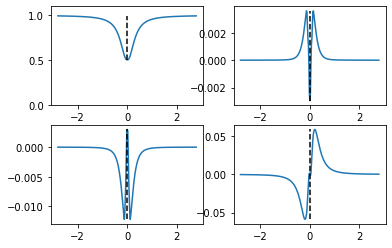

In [2]:
# PARAMETROS:
nlinea = 3                      # Numero linea en fichero
x = np.arange(-2.8,2.8,20e-3)   # Array Longitud de onda
B = 992.                        # Campo magnetico
gamma = np.deg2rad(134.)               # Inclinacion
xi = np.deg2rad(145.)                  # Angulo azimutal
vlos = 0.0                      # velocidad km/s
eta0 = 73.                      # Cociente de abs linea-continuo
a = 0.2                         # Parametro de amortiguamiento
ddop = 0.02                     # Anchura Doppler
# Sc = 4.0                      # Cociente Gradiente y Ordenada de la funcion fuente
S_0=0.5                         # Ordenada de la funcion fuente
S_1=0.5                         # Gradiente de la funcion fuente

param = paramLine(nlinea)
stokes = stokesSyn(param,x,B,gamma,xi,vlos,eta0,a,ddop,S_0,S_1)
for i in range(4):
    plt.subplot(2,2,i+1)
    if i == 0: plt.ylim(0,1.1)
    plt.plot(x,stokes[i])
    plt.plot([0,0],[min(stokes[i]),max(stokes[i])],'k--')

# LM- Milne

In [3]:
from lmfit import minimize, Parameters, fit_report
from LMmilne import *

----------------------------------------------------
Element = SI1
lambda0 = 10827.089
ju=2.0, lu=1, su=1.0
jl=2.0, ll=1, sl=1.0
g_u  = 1.50
g_l  = 1.50
geff = 1.50
----------------------------------------------------
pesos V: 16.679
pesos Q,U: 222.988, 160.273
--------------------------------------------------------------------
Time: 0.4116 s
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 189
    # data points      = 1120
    # variables        = 9
    chi-square         = 0.00139241
    reduced chi-square = 1.2533e-06
    Akaike info crit   = -15211.5414
    Bayesian info crit = -15166.3516
[[Variables]]
    B:      605.985184 +/- 10.8665473 (1.79%) (init = 639.9538)
    gamma:  2.50077659 +/- 0.01514764 (0.61%) (init = 2.348586)
    xi:     1.53647617 +/- 0.03602136 (2.34%) (init = 1.952555)
    vlos:  -0.24451874 +/- 0.03604944 (14.74%) (init = 1.1)
    eta0:   5.99999996 +/- 0.14417288 (2.40%) (init = 3)
    a:      0.50000000 +/- 0.01040380 (2.08%) (

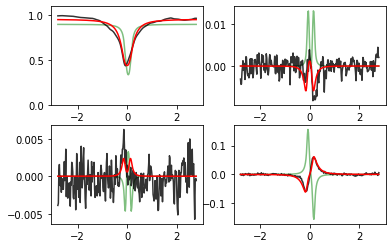

In [4]:
    # PARAMETROS:
    nlinea = 3                      # Numero linea en fichero
    x = arange(-0.3, 0.3, 1e-2)               # Array Longitud de onda
    B = 600.                        # Campo magnetico
    gamma = rad(30.)                    # Inclinacion
    xi = rad(160.)                      # Angulo azimutal
    vlos = 1.1
    eta0 = 3.                       # Cociente de abs linea-continuo
    a = 0.2                         # Parametro de amortiguamiento
    ddop = 0.05                         # Anchura Doppler
    S_0 = 0.3                         # Ordenada de la funcion fuente
    S_1 = 0.6                         # Gradiente de la funcion fuente
    Chitol = 1e-6
    Maxifev = 280
    pesoI = 1.
    pesoQ = 4.
    pesoU = 4.
    pesoV = 2.
    param = paramLine(nlinea)

    # Array de valores iniciales
    p=[B,gamma,xi,vlos,eta0,a,ddop,S_0,S_1]

    # Cargamos los datos:
    y2 = np.load('Profiles/stoke2.npy')
    x = np.arange(-2.8,2.8,20e-3)
    yc = list(y2[0])+list(y2[1])+list(y2[2])+list(y2[3])
    time0 = time.time()
    
    # Modulo Initial conditions:
    iB, igamma, ixi = initialConditions(y2,nlinea,x,param)
    ixi = rad(( grad(ixi) + 180. ) % 180.)
    igamma = rad(( grad(igamma) + 180. ) % 180.)

    # Array de valores iniciales
    p=[iB,igamma,ixi,vlos,eta0,a,ddop,S_0,S_1]
    
    
    ps = max(y2[0])/max(list(y2[1])+list(y2[2]))
    #print('Peso Q,U sugerido:',ps)
    pesoV = 1./max(y2[3])
    pesoQ = 1./max(y2[1])
    pesoU = 1./max(y2[2])
    
    print('----------------------------------------------------')
    print('pesos V: {0:2.3f}'.format(pesoV))
    print('pesos Q,U: {0:2.3f}, {1:2.3f}'.format(pesoQ, pesoU))

    # Establecemos los pesos
    peso = ones(len(yc))
    peso[0:int(len(yc)/4)] = pesoI
    peso[int(len(yc)/4):int(3*len(yc)/4)] = pesoQ
    peso[int(2*len(yc)/4):int(3*len(yc)/4)] = pesoU
    peso[int(3*len(yc)/4):] = pesoV


    print('--------------------------------------------------------------------')

    from math import pi
    p0 = Parameters()
    p0.add('B',     value=p[0], min=50.0, max= 2000.)
    p0.add('gamma', value=p[1], min=0., max = pi)
    p0.add('xi',    value=p[2], min=0., max = pi)
    p0.add('vlos',  value=p[3], min=-20., max =+20.)
    p0.add('eta0',  value=p[4], min=0., max = 6.)
    p0.add('a',     value=p[5], min=0., max = 0.5)
    p0.add('ddop',  value=p[6], min=0.0, max = 0.5)
    p0.add('S_0',   value=p[7], min=0.0,  max = 1.5)
    p0.add('S_1',   value=p[8], min=0.0,  max = 1.5)
    
    stokes0 = stokesSyn(param,x,B,gamma,xi,vlos,eta0,a,ddop,S_0,S_1)
    
    [ysync, out] = inversionStokes(p0,x,yc,param,Chitol,Maxifev,peso)
    print('Time: {0:2.4f} s'.format(time.time()-time0)) 
    print(fit_report(out, show_correl=False))


    # plot section:
    import matplotlib.pyplot as plt

    stokes = list(split(yc, 4))
    synthetic = list(split(ysync, 4))
    for i in range(4):
        plt.subplot(2,2,i+1)
        if i == 0: plt.ylim(0,1.1)
        plt.plot(x,stokes0[i],'g-', alpha=0.5)
        plt.plot(x,stokes[i],'k-',alpha =0.8)
        plt.plot(x,synthetic[i],'r-')